<a href="https://colab.research.google.com/github/Neo-Julio/ml4HepNotebook/blob/main/Tempotron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook builds a CNN based on the tempotron DataSet
link: https://zenodo.org/records/7974151

bui

In [21]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [3]:
!wget https://zenodo.org/records/7974151/files/Dataset.zip?download=1 -O dataset.zip

--2025-07-31 13:00:14--  https://zenodo.org/records/7974151/files/Dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6755452 (6.4M) [application/octet-stream]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   6.44M  1.43MB/s    in 4.7s    

2025-07-31 13:00:19 (1.37 MB/s) - ‘dataset.zip’ saved [6755452/6755452]



In [4]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: Dataset/dataset/
   creating: Dataset/dataset/training_dataset/
  inflating: Dataset/dataset/training_dataset/labels.mat  
  inflating: Dataset/dataset/training_dataset/train_labels.txt  
  inflating: Dataset/dataset/training_dataset/training_data_normalized.txt  
   creating: Dataset/dataset/validation_dataset/
 extracting: Dataset/dataset/validation_dataset/labels.mat  
  inflating: Dataset/dataset/validation_dataset/test_labels.txt  
  inflating: Dataset/dataset/validation_dataset/validation_data_normalized.txt  


Now let's visualize the data

In [39]:
!ls Dataset/dataset/validation_dataset/

#!ls -l dataset/training_dataset

labels.mat  test_labels.txt  validation_data_normalized.txt


Some information about the DataSet

In [40]:

x_train = np.loadtxt("Dataset/dataset/training_dataset/training_data_normalized.txt", delimiter=",")
y_train = np.loadtxt("Dataset/dataset/training_dataset/train_labels.txt", delimiter=",").astype(int)

x_val = np.loadtxt("Dataset/dataset/validation_dataset/validation_data_normalized.txt", delimiter=",")
y_val = np.loadtxt("Dataset/dataset/validation_dataset/test_labels.txt", delimiter=",").astype(int)

print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(1000, 280)
(1000,)
(8404, 280)
(8404,)


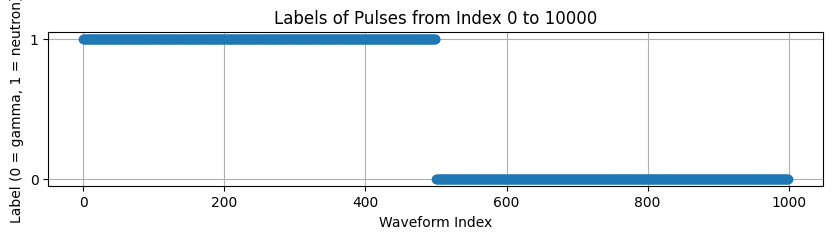

In [64]:
plt.figure(figsize=(10, 2))
plt.plot(y_train[0:1000], 'o')
plt.title("Labels of Pulses from Index 0 to 10000")
plt.xlabel("Waveform Index")
plt.ylabel("Label (0 = gamma, 1 = neutron)")
plt.yticks([0, 1])
plt.grid(True)
#plt.show()

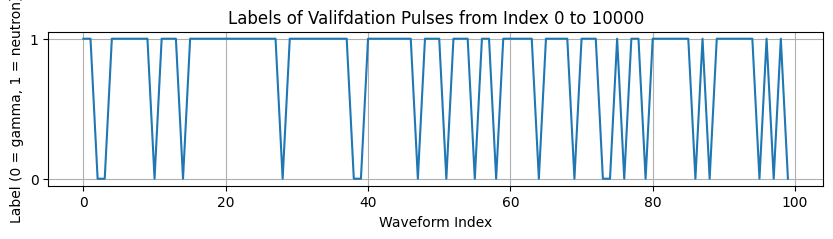

In [54]:
plt.figure(figsize=(10, 2))
plt.plot(y_val[0:100])
plt.title("Labels of Valifdation Pulses from Index 0 to 10000")
plt.xlabel("Waveform Index")
plt.ylabel("Label (0 = gamma, 1 = neutron)")
plt.yticks([0, 1])
plt.grid(True)
plt.show()

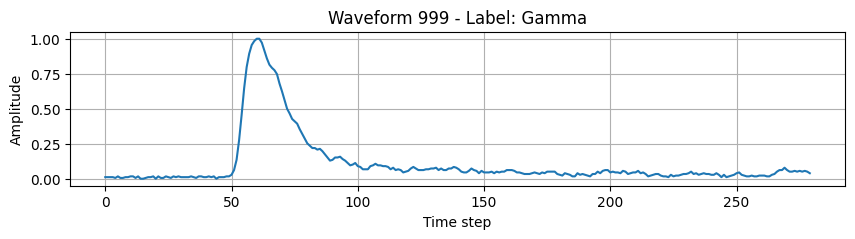

In [68]:
i = 999
plt.figure(figsize=(10, 2))
plt.plot(x_train[i])
label = 'Neutron' if y_train[i] == 1 else 'Gamma'
plt.title(f"Waveform {i} - Label: {label}")
plt.xlabel("Time step")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


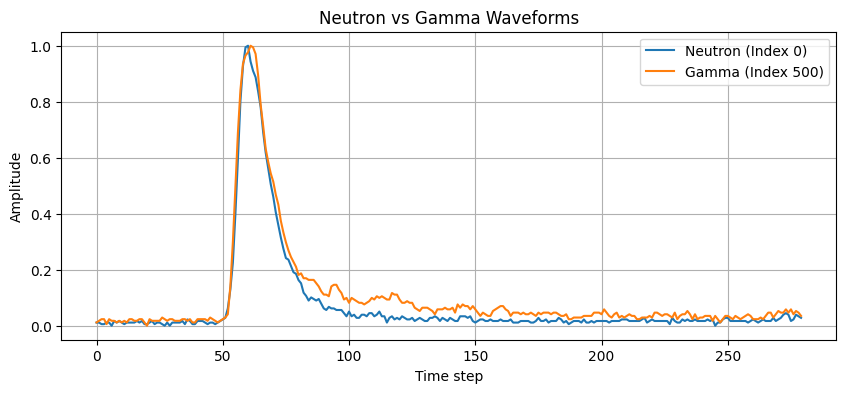

In [70]:
# Find one neutron and one gamma index
neutron_idx = np.where(y_train == 1)[0][0]
gamma_idx = np.where(y_train == 0)[0][0]

plt.figure(figsize=(10, 4))
plt.plot(x_train[neutron_idx], label=f"Neutron (Index {neutron_idx})")
plt.plot(x_train[gamma_idx], label=f"Gamma (Index {gamma_idx})")

plt.title("Neutron vs Gamma Waveforms")
plt.xlabel("Time step")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

Now let's build a 1D CNN.

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PulseCNN(nn.Module):
    def __init__(self):
        super(PulseCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv1d(32, 64, 3, padding=1)

        # Compute final flattened size after pooling:
        # Input length: 280
        # After pool1 (stride=2): 140
        # After pool2: 70
        # After pool3: 70 (no pool after conv3)
        self.fc1 = nn.Linear(64 * 70, 128)
        self.fc2 = nn.Linear(128, 2)  # output 2 classes

    def forward(self, x):
        # x shape: (batch_size, 1, 280)
        x = self.pool(F.relu(self.conv1(x)))  # (batch_size, 16, 140)
        x = self.pool(F.relu(self.conv2(x)))  # (batch_size, 32, 70)
        x = F.relu(self.conv3(x))              # (batch_size, 64, 70)
        x = x.view(x.size(0), -1)              # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
